<a href="https://colab.research.google.com/github/tripatheea/transform/blob/main/curriculum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy import interpolate
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers
from sklearn.model_selection import train_test_split

In [3]:
min_log_depth = 0
max_log_depth = 2

depths = 10**np.linspace(min_log_depth, max_log_depth, 20000)


In [4]:
min(depths), max(depths)

(1.0, 100.0)

In [27]:
breaks = [10.0, 20.0, 30.0, 50.0, 80.0]

breaks_idx = [0] + [np.argmin(np.abs(depths - b)) for b in breaks] + [len(depths) - 1]

breaks_idx

[0, 9999, 13010, 14770, 16989, 19030, 19999]

In [28]:
data = np.load(f'/content/drive/MyDrive/transform/depth_varied_1_to_100_injs.npz')

path = '/content/drive/MyDrive/transform/depths_varied_1_to_100/'



In [29]:
all_x, all_y = data['x'], data['y']

In [30]:
all_train_metrics = {'loss': [], 'accuracy': [], 'p_det': []}
all_val_metrics = {'loss': [], 'accuracy': [], 'p_det': []}
all_test_p_dets = []
all_test_fpr_s = []
all_test_tpr_s = []

In [31]:
def get_dataset(br_idx_i):
    shuffle = False

    current_iter_x, current_iter_y = all_x[breaks_idx[br_idx_i]:breaks_idx[br_idx_i + 1]], all_y[breaks_idx[br_idx_i]:breaks_idx[br_idx_i + 1]]

    x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(current_iter_x, current_iter_y, test_size=0.4, random_state=42, shuffle=shuffle)
    x_test_s, x_val_s, y_test_s, y_val_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=26, shuffle=shuffle)

    print(x_train_s.shape, x_val_s.shape, x_test_s.shape)

    batch_size = 32

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_s, y_test_s)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val_s, y_val_s)).batch(batch_size)

    return train_dataset, test_dataset, val_dataset, x_test_s, y_test_s

# checkpoint_filepath = f


def plot_history(history, test_dataset, x_test_s, y_test_s, title):

    plt.figure(figsize=(18, 4))

    plt.subplot(141)

    plt.plot(np.arange(0, EPOCHS), history.history['loss'], label="Training Loss", marker="x", ms=3)
    plt.plot(np.arange(0, EPOCHS), history.history['val_loss'], label="Validation Loss", marker="x", ms=3)

    plt.legend()

    plt.subplot(142)

    metric = 'p_det'

    plt.plot(np.arange(0, EPOCHS), history.history[metric], label="Training pdet", marker="x", ms=3)
    plt.plot(np.arange(0, EPOCHS), history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

    plt.ylim(0, 1)

    plt.legend()

    plt.subplot(143)

    metric = 'accuracy'

    plt.plot(np.arange(0, EPOCHS), history.history[metric], label="Training pdet", marker="x", ms=3)
    plt.plot(np.arange(0, EPOCHS), history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

    plt.ylim(0, 1)

    plt.legend()


    plt.subplot(144)
    result = tf_model.evaluate(test_dataset)

    test_predicted_ys = tf_model.predict(x_test_s)
    fpr, tpr, thresholds = roc_curve(y_test_s, test_predicted_ys)

    p_det = interpolate.interp1d(fpr, tpr)(0.01)

    print(f"\n\ntest p_det is {p_det:.4f}.\n\n")

    all_test_tpr_s.append(tpr)
    all_test_fpr_s.append(fpr)
    all_test_p_dets.append(p_det)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], ls="dotted", lw=0.5)
    plt.grid(alpha=0.3, ls="dotted")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.suptitle(title)

    plt.tight_layout()

    for m in ['loss', 'accuracy', 'p_det']:
        all_train_metrics[m].append(history.history[m])
        all_val_metrics[m].append(history.history['val_' + m])

In [32]:
def get_p_det_metric(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return np.interp(0.01, fpr, tpr)
    
def p_det(y_true, y_pred): 
    return tf.numpy_function(get_p_det_metric, (y_true, y_pred), tf.double)

def get_model():
    act = 'relu'

    reg = tf.keras.regularizers.L2(
        l2=0.000000001)

    input = tf.keras.Input(shape=(all_x.shape[1], all_x.shape[2], all_x.shape[3],))
    x_layer = tf.keras.layers.Conv1D(64, (100), strides=16, kernel_regularizer=reg, activation=act, kernel_initializer='he_normal')(input)
    x_layer = tf.keras.layers.Conv2D(64, (2, 16), kernel_regularizer=reg, strides=(1, 4), activation=act, kernel_initializer='he_normal')(x_layer)
    x_layer = tf.keras.layers.Flatten()(x_layer)
    # x = tf.keras.layers.Dense(16, activation=act)(x)
    x_layer = tf.keras.layers.Dense(32, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(16, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(8, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(4, activation=act, kernel_regularizer=reg)(x_layer)
    x_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x_layer)

    tf_model = tf.keras.Model(inputs=input, outputs=x_layer)

    return tf_model

tf_model = get_model()

In [11]:
tf_model.compile(
                optimizer='adam',
                 loss='binary_crossentropy',
              metrics=['accuracy', p_det],
                )

tf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 382, 4)]      0         
                                                                 
 conv1d (Conv1D)             (None, 10, 18, 64)        25664     
                                                                 
 conv2d (Conv2D)             (None, 9, 1, 64)          131136    
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 32)                18464     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136   

0 9999

depth = 1.00, 10.00

(5999, 10, 382, 4) (2000, 10, 382, 4) (2000, 10, 382, 4)
63/63 [==============================] - 1s 12ms/step


test p_det is 0.9770.




9999 14770

depth = 10.00, 30.00

(2862, 10, 382, 4) (955, 10, 382, 4) (954, 10, 382, 4)
30/30 [==============================] - 0s 13ms/step


test p_det is 0.2753.




14770 16989

depth = 30.00, 50.00

(1331, 10, 382, 4) (444, 10, 382, 4) (444, 10, 382, 4)
14/14 [==============================] - 0s 21ms/step


test p_det is 0.0583.




16989 19030

depth = 50.00, 80.00

(1224, 10, 382, 4) (409, 10, 382, 4) (408, 10, 382, 4)
13/13 [==============================] - 0s 12ms/step


test p_det is 0.0099.




19030 19999

depth = 80.00, 100.00

(581, 10, 382, 4) (194, 10, 382, 4) (194, 10, 382, 4)
19/19 [==============================] - 1s 59ms/step - loss: 0.7467 - accuracy: 0.5404 - p_det: 0.1000 - val_loss: 0.6890 - val_accuracy: 0.5619 - val_p_det: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


7/7 [==============================] - 0s 11ms/step


test p_det is 0.0000.




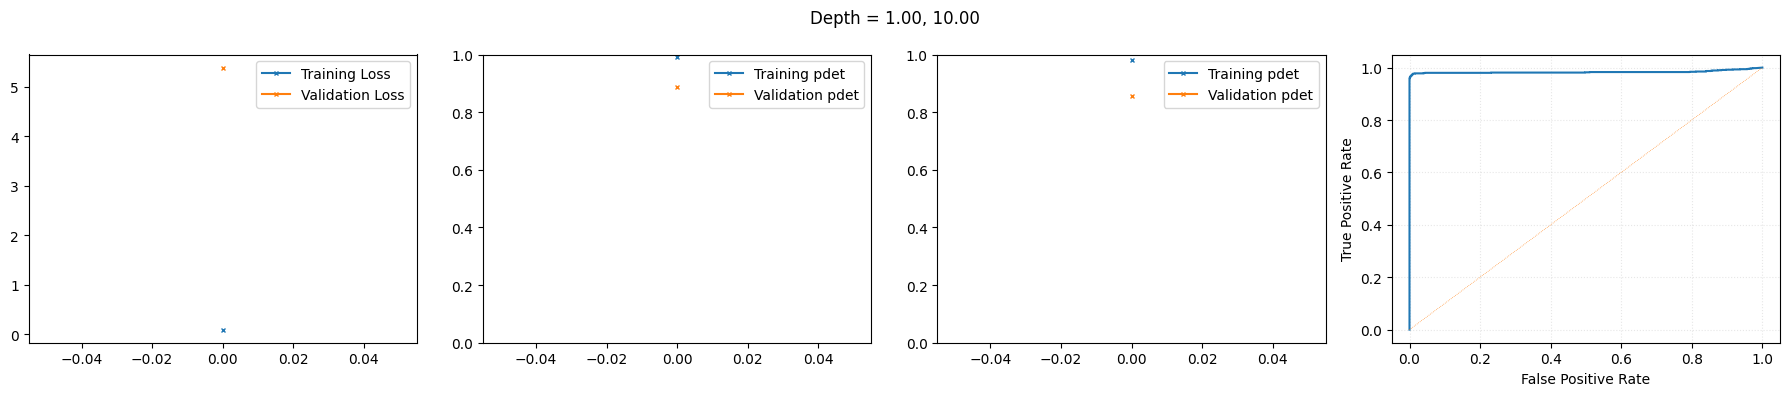

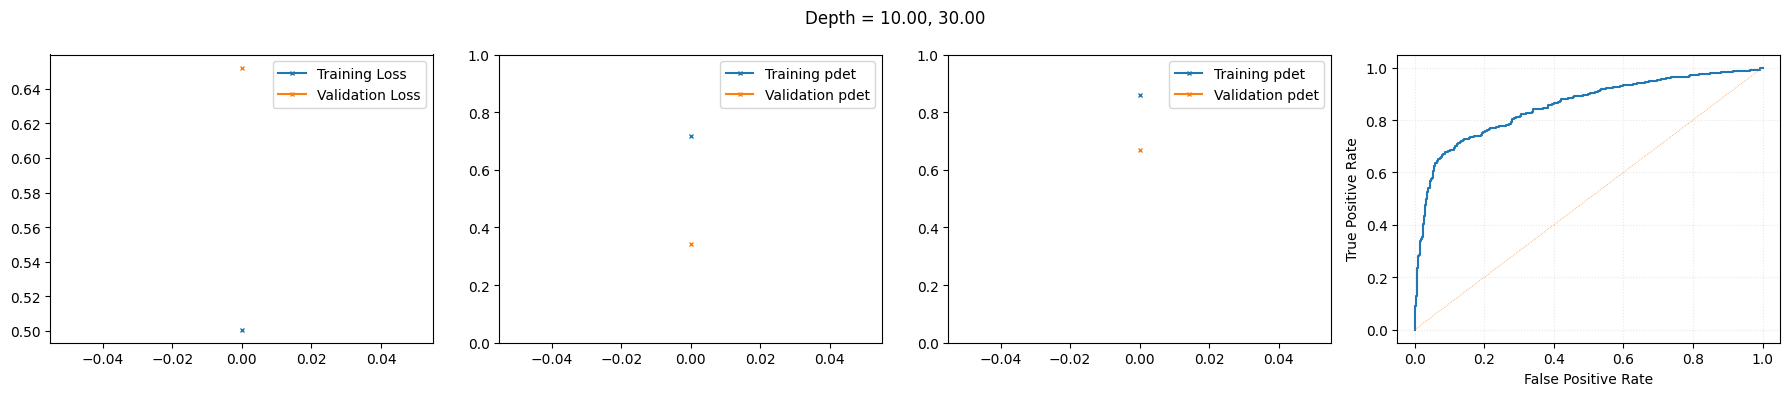

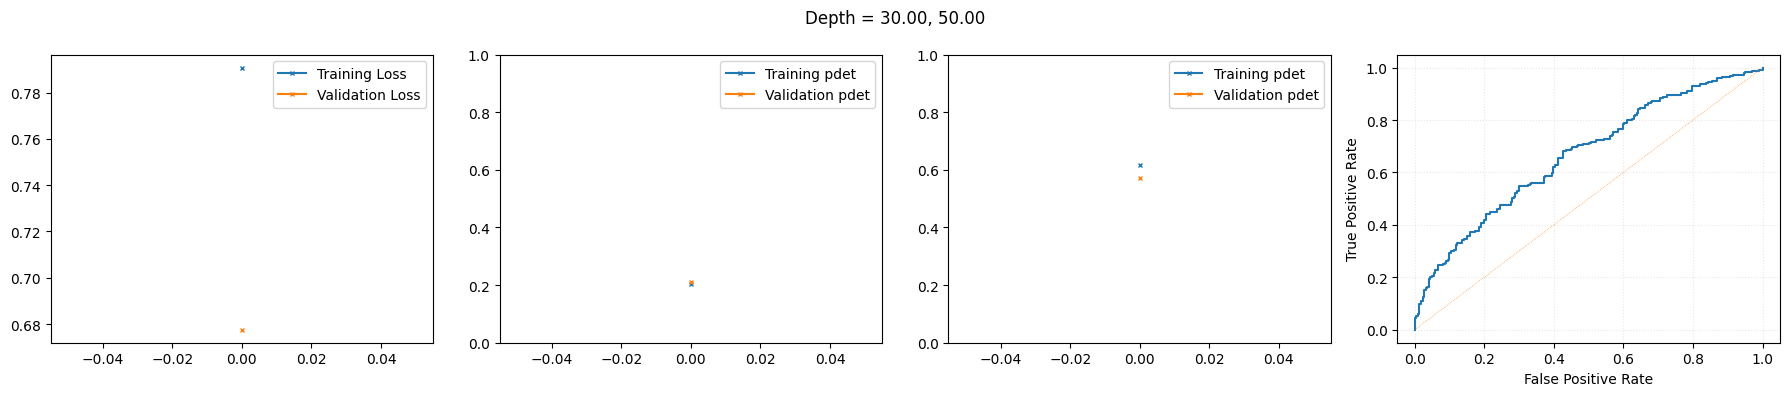

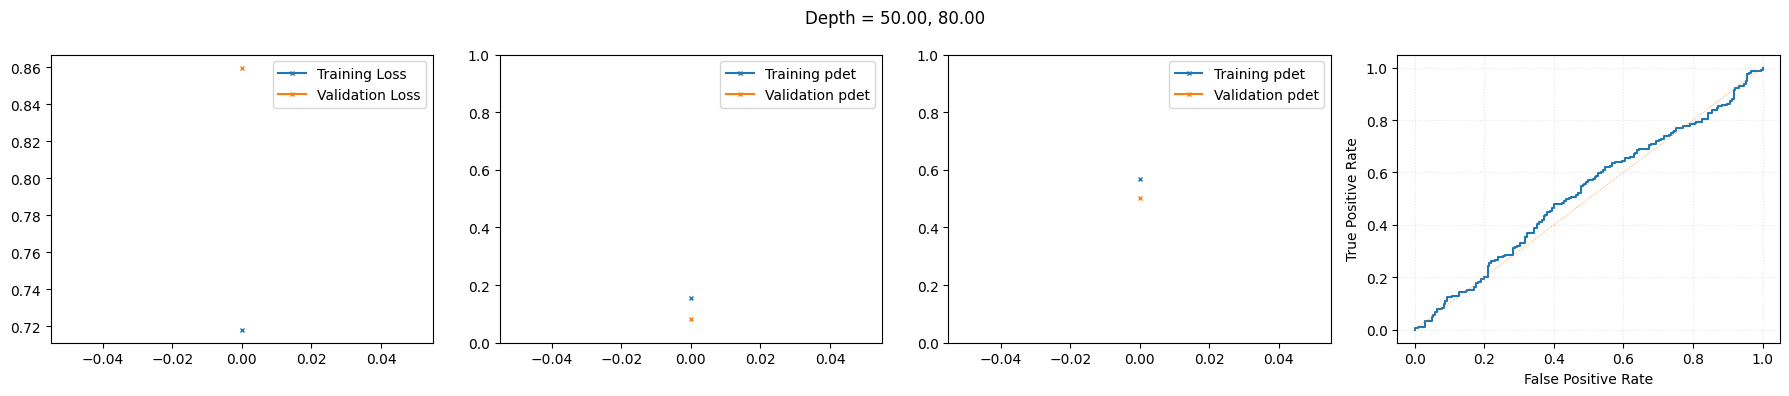

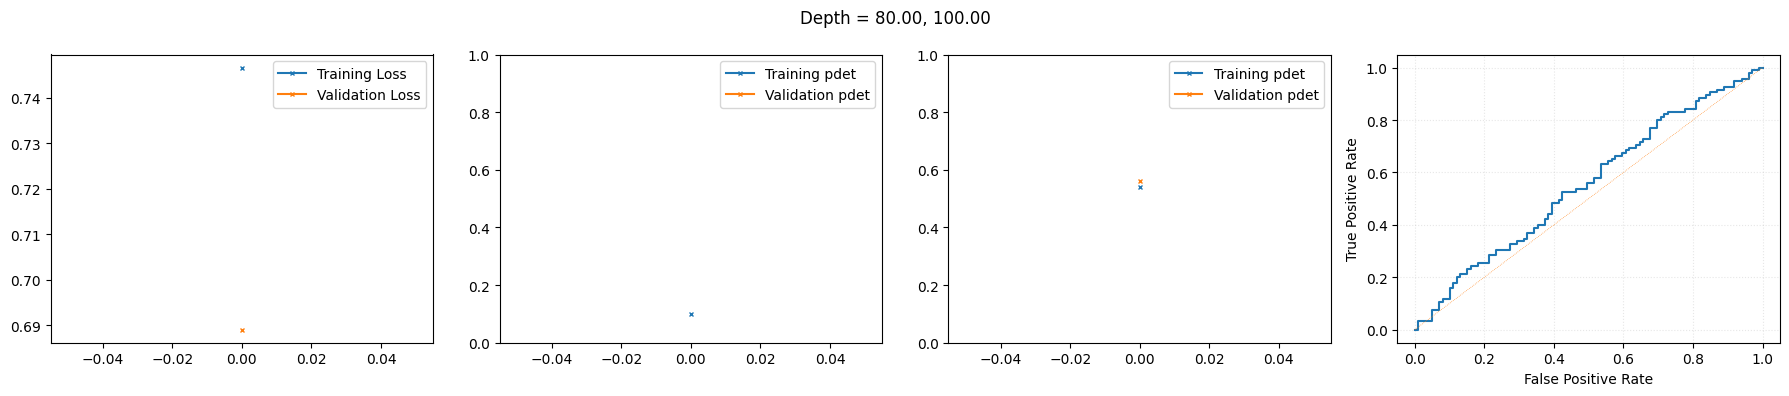

In [25]:
EPOCHS = 1

for br_idx_i in range(len(breaks_idx) - 1):

    min_depth, max_depth = depths[breaks_idx[br_idx_i]], depths[breaks_idx[br_idx_i + 1]]

    print(breaks_idx[br_idx_i], breaks_idx[br_idx_i + 1])
    print(f"\ndepth = {min_depth:.2f}, {max_depth:.2f}\n")


    train_dataset, test_dataset, val_dataset, x_test_s, y_test_s = get_dataset(br_idx_i)


    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/transform/depths_varied_1_to_100/weights/weights.depth_" + f"{min_depth:.2f}_{max_depth:.2f}" + "_epoch_{epoch:02d}-val_p_det_{val_p_det:.2f}.hdf5",
    save_weights_only=True,
    monitor='val_p_det',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=False)

    history = tf_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[model_checkpoint_callback])

    plot_history(history, test_dataset, x_test_s, y_test_s, title=f"Depth = {min_depth:.2f}, {max_depth:.2f}")


    model_path = path + '/saved_models'
    !mkdir -p model_path
    tf_model.save(model_path + f'/my_model_depths_{min_depth:.2f}_{max_depth:.2f}')

    # break

In [15]:
# all_train_metrics

In [16]:
# all_fpr_s